## Quick Guide


The notebook works as a simple script to download data from CDMNext using CEIC's Python package, extracts all series and plot a map with the data.

> #### Installation Guide
>
> 1. Install Python 3.9+
> 2. Open terminal and execute
>  - pip install --extra-index-url https://downloads.ceicdata.com/python ceic_api_client
>  - pip install --extra-index-url https://downloads.ceicdata.com/python ceic_api_client --upgrade
---

> #### Usage Guide
>
> **Import libraries** - cell to define libraries we need to set before running the code<br />
> **Connect to CEIC API Client** - log in with credentials to get full acces to the data<br />
> **Download the data** - download the series<br />
> **Code Execution** - run the main program based on parameters and functions<br />
> 
>
> Visit **[CEIC Main Page](https://www.ceicdata.com/en)** for more information on how to use our data and the PyCEIC package.
>

## Map Tutorial

Install needed packages

In [1]:
from ceic_api_client.pyceic import Ceic #Call CEIC client

import numpy as np
import pandas as pd 
import openpyxl
%matplotlib notebook

import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.image as mpimg

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox, OffsetBox)

from matplotlib.colors import Normalize # Needed for color maps
from matplotlib.cm import ScalarMappable # Needed for color maps
from matplotlib.patches import Patch # Needed for adding figures

A. Log in with CEIC Credentials

In [2]:
workbook = openpyxl.load_workbook(r'C:\Users\necheverry\OneDrive - Internet Securities, LLC\Documents\Documentos\CEIC\Scripts\Python\credentials.xlsx')
sheet = workbook.active
user = sheet['A2'].value
pasw = sheet['B2'].value
Ceic.login(user,pasw)

C:\Users\necheverry\Anaconda3\lib\site-packages\ceic_api_client\facade\pyceic_warnings.py:83: UserWarning: 
interaction interface to CEIC macroeconomic data and
any data usage abuse attempt will be recorded.
  warnings.warn(message=self._WARNING_MESSAGE, category=UserWarning)


Daily Average Temperature
https://insights.ceicdata.com/node/DAILY__DAILY&&ALT__TP3839917__SC3883317

TB4101247 = Asia and Central Asia <br>
TB4101047 = Eastern and Western Europe <br>
TB4448737 = Northern and Southern Europe <br>
TB4101127 = Middle East and Africa <br>
TB4101197 = North America <br>
TB4448307 = South America <br>

In [4]:
def get_series_to_df(id_insight,initial_date):
    
    '''This function takes series id, download each series and build a dataframe in long format'''
    
    # Divide full list of series in sublist of 20 elements for download with Ceic.series()
    codigos = [i for i in id_insight]
    sub_listas = [codigos[i:i + 20] for i in range(0, len(codigos), 20)]
    
    data_list = [] 

    # Download each sublist
    for sub_lista in sub_listas:
        result = Ceic.series(sub_lista, start_date=initial_date)
        
        for series in result.data:
            metadata_info = series.metadata #Extract metadata information
            time_points_info = series.time_points #Extract all time points and values

            # Extract general information for variables
            indicator_name = metadata_info.name
            country = metadata_info.country.name
            id_country = metadata_info.country.id
            unit = metadata_info.unit.name

            # Extract each timepoinn and value
            for point in time_points_info:
                date = point.date
                value = point.value

                # Add to the list of results
                data_list.append({
                    'indicator_name': indicator_name,
                    'country': country,
                    'id_country': id_country,
                    'date': date,
                    'value': value,
                    'unit': unit
                })
    
    #Convert list of information to dataframe
    df = pd.DataFrame(data_list)
    
    # Sort by date
#     df_sorted = df.sort_index(ascending=True)
    
    return df           

# Global Map

B. Data Extraction

In [5]:
code_list_global = ['TB4101247','TB4101047','TB4448737','TB4101127','TB4101197','TB4448307']

series_codes_global = []
for i in code_list_global:
    r = Ceic.layout_table_series(i, status = 'T')
    for c in r.data:
        series_codes_global.append(c.metadata.id)

print(len(series_codes_global))

9221


In [6]:
df_global_long = get_series_to_df(series_codes_global,'2020-12-01')
df_global_long.head()

,indicator_name,country,id_country,date,value,unit
0,Global Temperature: Daily Average: Australia: ...,Australia,AU,2023-12-29,18.00,Degrees Celsius
1,Global Temperature: Daily Average: Australia: ...,Australia,AU,2023-12-28,16.30,Degrees Celsius
2,Global Temperature: Daily Average: Australia: ...,Australia,AU,2023-12-27,18.50,Degrees Celsius
3,Global Temperature: Daily Average: Australia: ...,Australia,AU,2023-12-26,19.70,Degrees Celsius
4,Global Temperature: Daily Average: Australia: ...,Australia,AU,2023-12-25,20.75,Degrees Celsius


In [18]:
len(df_global_long)

9839449

1. Calculate average by country and date
2. Calculate the weekly average
3. Interpolate the missing data

In [99]:
# Calculate the average value by Country, Year and Month
df_long_country = df_global_long.groupby(['country', 'id_country','date'])['value'].mean().reset_index()

df_long_country_w = df_long_country[:]
df_long_country_w['date'] = pd.to_datetime(df_long_country_w['date'])
df_long_country_w.set_index('date', inplace=True) #Establish 'date' as index

# Group by 'id_country' y and resample by a weekly frequency 
weekly_avg = df_long_country_w.groupby(['country','id_country']).resample('W').mean()

#Interpolate missing values (linear interpolation)
weekly_avg['value'] = weekly_avg.groupby(['id_country'])['value'].apply(lambda x: x.interpolate())

# Reset Index
weekly_avg.reset_index(inplace=True)
weekly_avg

,country,id_country,date,value
0,Albania,AL,2020-12-06,9.809259
1,Albania,AL,2020-12-13,9.596825
2,Albania,AL,2020-12-20,8.038889
3,Albania,AL,2020-12-27,10.276190
4,Albania,AL,2021-01-03,10.868254
...,...,...,...,...
27832,Zimbabwe,ZW,2023-12-03,26.525758
27833,Zimbabwe,ZW,2023-12-10,25.772123
27834,Zimbabwe,ZW,2023-12-17,23.698056
27835,Zimbabwe,ZW,2023-12-24,23.999476


Calculate the global weekly average

In [100]:
df_w = weekly_avg[:]
df_w['date'] = pd.to_datetime(df_w['date'])
df_w.sort_values(by=['country','date'], inplace=True)

# Extraer el año y el mes y crear nuevas columnas para ellos
df_w['year'] = df_w['date'].dt.year
df_w['month'] = df_w['date'].dt.month

# Calculate global average temperature by month and year
global_monthly_avg = df_w.groupby(['year', 'month'])['value'].mean().reset_index(name='global_monthly_avg')
df_w = df_w.merge(global_monthly_avg, on=['year', 'month'], how='left')

df_avg_w = df_w.loc[:,['date','global_monthly_avg']]
df_avg_w = df_avg_w.set_index('date')
df_avg_w = df_avg_w.groupby(df_avg_w.index).mean()

df_avg_w

,global_monthly_avg
date,
2020-12-06,16.433743
2020-12-13,16.433743
2020-12-20,16.433743
2020-12-27,16.433743
2021-01-03,15.534581
...,...
2023-12-03,17.073017
2023-12-10,17.073017
2023-12-17,17.073017


### Empty Map

<IPython.core.display.Javascript object>


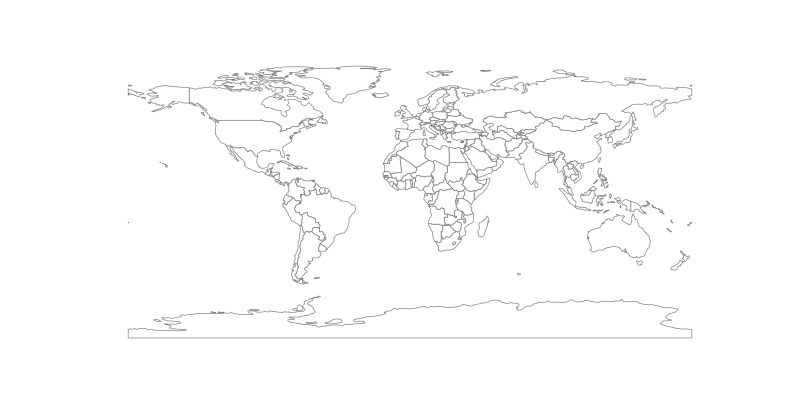

In [140]:
#Import the world shapefile 
world = gpd.read_file(r'countries.shp')

fig, ax = plt.subplots(figsize=(8,4))
world.plot(linewidth=0.5, edgecolor='grey', legend=False, color='white', ax=ax)

ax.set_axis_off() #Hide the axes

plt.show()

## Basic Map

C:\Users\necheverry\AppData\Local\Temp\ipykernel_10952\404496055.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_week['date'] = pd.to_datetime(single_week['date'])


<IPython.core.display.Javascript object>


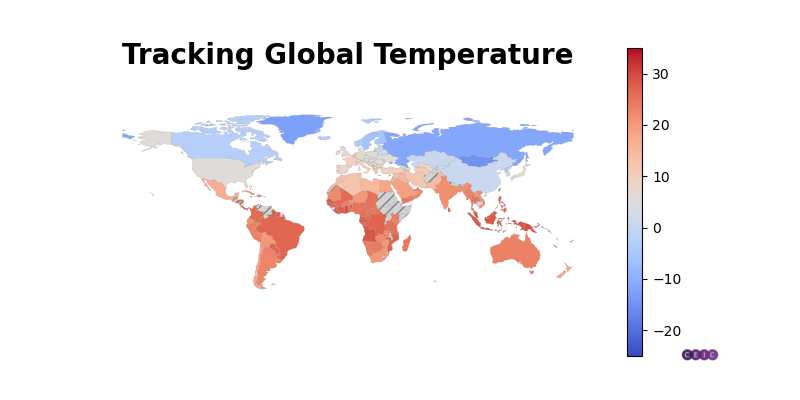

In [199]:
world = gpd.read_file(r'countries.shp')

# Fix some missing codes
world.loc[world['ADMIN'] == 'Norway', 'ISO_A2'] = 'NO' #Norway
world.loc[world['ADMIN'] == 'France', 'ISO_A2'] = 'FR' #France

# Exclude Antarctica
world = world[world['ADMIN'] != 'Antarctica']

# Set the 'date' column as DateTime
single_week = df_w[df_w['date']=='2023-12-31']
single_week['date'] = pd.to_datetime(single_week['date'])

fig, ax = plt.subplots(figsize=(8,4))
# Add CEIC logo
# Import logo in .png
im = r'C:\Users\necheverry\OneDrive - Internet Securities, LLC\Documents\Documentos\CEIC\Scripts\Python\ceic_logo_png-sinfondo.png'
img = mpimg.imread(im)
ax_img = fig.add_axes([0.85, 0.08, 0.05, 0.05], anchor='NE', xticks=[], yticks=[], frame_on=False)
ax_img.imshow(img)

# Define the coordinates where the logo will be displayed
# The coordinates mean: left, bottom, width and height
map_for_date = world.merge(single_week, how='left', left_on='ISO_A2', 
                           right_on='id_country')
    
# Draw the base map
map_for_date.plot(column='value', cmap='coolwarm', linewidth=0.1, 
                  ax=ax, edgecolor='grey', legend=True, vmin=-25, 
                  vmax=35, missing_kwds={'color': 'lightgrey', 'hatch': '///'})
    
ax.set_title(f'Tracking Global Temperature', fontsize=20, pad=30, weight='bold')

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis('off')

# Display the chart
plt.show()
fig.savefig('single_map.png')

### Map with legend

C:\Users\necheverry\AppData\Local\Temp\ipykernel_10952\366492190.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_week['date'] = pd.to_datetime(single_week['date'])


<IPython.core.display.Javascript object>


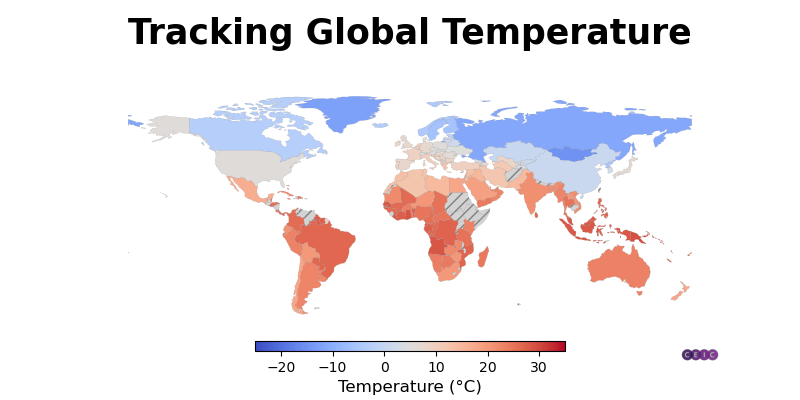

In [210]:
world = gpd.read_file(r'countries.shp')

world.loc[world['ADMIN'] == 'Norway', 'ISO_A2'] = 'NO' #Norway
world.loc[world['ADMIN'] == 'France', 'ISO_A2'] = 'FR' #France
world = world[world['ADMIN'] != 'Antarctica']

# Set the 'date' column as DateTime
single_week = df_w[df_w['date']=='2023-12-31']
single_week['date'] = pd.to_datetime(single_week['date'])

fig, ax = plt.subplots(figsize=(8,4))
# Add a logo
im = r'C:\Users\necheverry\OneDrive - Internet Securities, LLC\Documents\Documentos\CEIC\Scripts\Python\ceic_logo_png-sinfondo.png'
img = mpimg.imread(im)
ax_img = fig.add_axes([0.85, 0.08, 0.05, 0.05], anchor='NE', xticks=[], yticks=[], frame_on=False)
ax_img.imshow(img)

# Define the coordinates where the logo will be displayed
# The coordinates mean: left, bottom, width and height
map_for_date = world.merge(single_week, how='left', left_on='ISO_A2', right_on='id_country')
    
map_for_date.plot(column='value', cmap='coolwarm', linewidth=0.1, ax=ax, edgecolor='grey',
                  legend=False, vmin=-25, vmax=35, missing_kwds={'color': 'lightgrey', 'hatch': '///'})
    
ax.set_title(f'Tracking Global Temperature', fontsize=25, pad=30, weight='bold')

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis('off')

# Color normalization
norm = Normalize(vmin=-25, vmax=35)
# Create color bar
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='coolwarm'), 
                    ax=ax, orientation='horizontal', pad=0.05, 
                    fraction=0.05, aspect=30, shrink=0.5)
cbar.set_label('Temperature (°C)', fontsize=12)

# Display the chart
plt.show()
fig.savefig('legend_map.png')

### Map with customizations

C:\Users\necheverry\AppData\Local\Temp\ipykernel_10952\1194707617.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_week['date'] = pd.to_datetime(single_week['date'])


<IPython.core.display.Javascript object>


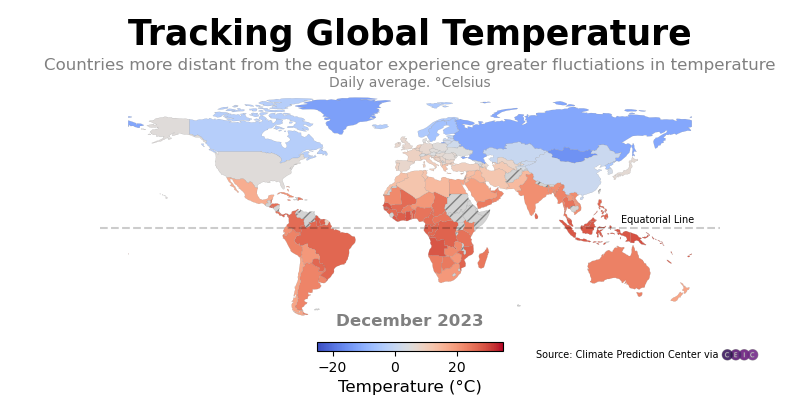

In [197]:
world = gpd.read_file(r'countries.shp')

# Fix some missing codes
world.loc[world['ADMIN'] == 'Norway', 'ISO_A2'] = 'NO' #Norway
world.loc[world['ADMIN'] == 'France', 'ISO_A2'] = 'FR' #France
world = world[world['ADMIN'] != 'Antarctica']

# Set the 'date' column as DateTime
single_week = df_w[df_w['date']=='2023-12-31']
single_week['date'] = pd.to_datetime(single_week['date'])

fig, ax = plt.subplots(figsize=(8,4))
im = r'C:\Users\necheverry\OneDrive - Internet Securities, LLC\Documents\Documentos\CEIC\Scripts\Python\ceic_logo_png-sinfondo.png'
img = mpimg.imread(im)
ax_img = fig.add_axes([0.9, 0.08, 0.05, 0.05], anchor='NE', xticks=[], yticks=[], frame_on=False)
ax_img.imshow(img)

# Define the coordinates where the logo will be displayed
# The coordinates mean: left, bottom, width and height
map_for_date = world.merge(single_week, how='left', left_on='ISO_A2', right_on='id_country')
    
map_for_date.plot(column='value', cmap='coolwarm', linewidth=0.1, ax=ax, edgecolor='grey',
                  legend=False, vmin=-25, vmax=35, missing_kwds={'color': 'lightgrey', 'hatch': '///'})

# Add title and annotations
ax.set_title(f'Tracking Global Temperature', fontsize=25, pad=30, weight='bold')

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis('off')
    
ax.annotate('December 2023',xy=(0.5,0), xytext=(0,0), xycoords='axes fraction', 
            textcoords='offset points', ha='center', fontsize=12, color='grey', weight='bold')
    
ax.annotate('Countries more distant from the equator experience greater fluctuations in temperature',
            xy=(0.5,1.07), xytext=(0,0), xycoords='axes fraction', textcoords='offset points', 
            ha='center', fontsize=12, color='grey')
    
ax.annotate('Daily average. °Celsius',xy=(0.5,1), xytext=(0,0), xycoords='axes fraction', 
            textcoords='offset points', ha='center', fontsize=10, color='grey')
    
ax.annotate('Source: Climate Prediction Center via',xy=(0.85,-0.13), xytext=(0,0), 
            xycoords='axes fraction', textcoords='offset points', ha='center', fontsize=7, 
            color='black')
    
ax.axhline(y=0.5, color='black', linestyle='--', alpha=0.2)
    
ax.annotate('Equatorial Line',xy=(0.9,0.43), xytext=(0,0), xycoords='axes fraction', 
            textcoords='offset points', ha='center', fontsize=7, color='black', weight='normal')

norm = Normalize(vmin=-25, vmax=35)
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='coolwarm'), ax=ax, orientation='horizontal', pad=0.05, fraction=0.046, aspect=20, shrink=0.3)
cbar.set_label('Temperature (°C)', fontsize=12)

# Display the chart
plt.show()
fig.savefig('better_map.png')

## Animation

<IPython.core.display.Javascript object>


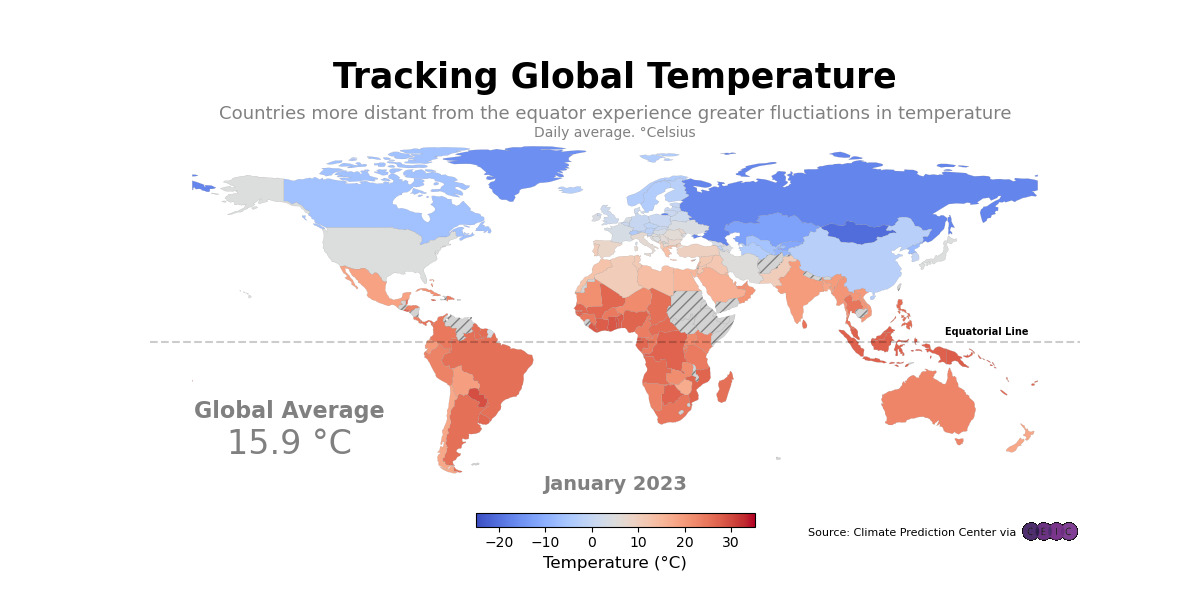

In [132]:
# Load world ,ap
world = gpd.read_file(r'countries.shp')

# Fix some missing codes
world.loc[world['ADMIN'] == 'Norway', 'ISO_A2'] = 'NO' #Norway
world.loc[world['ADMIN'] == 'France', 'ISO_A2'] = 'FR' #France

# Exclude Antarctica
world = world[world['ADMIN'] != 'Antarctica']

# Set the 'date' column as DateTime
df_w['date'] = pd.to_datetime(df_w['date'])

# Add logo
im = r'C:\Users\necheverry\OneDrive - Internet Securities, LLC\Documents\Documentos\CEIC\Scripts\Python\ceic_logo_png-sinfondo.png'
img = mpimg.imread(im)

# Initialization function
def init():
    world.plot(ax=ax, color='lightgrey', edgecolor='black')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.axis('off')
    ax.set_title('', fontsize=20, pad=10)

    return ax,

# Animate function to update each frame
def animate(date):
    # Clear the axes each iteration
    ax.clear()
    # Filter data based on current date
    current_data = df_w[df_w['date'] == date]
    # Merge the data with the world dataframe
    map_for_date = world.merge(current_data, how='left', left_on='ISO_A2', right_on='id_country')
    # Plot the current data on each interation
    map_for_date.plot(column='value', cmap='coolwarm', linewidth=0.1, ax=ax, edgecolor='grey',
                      legend=False, vmin=-25, vmax=35, missing_kwds={'color': 'lightgrey', 'hatch': '///'})
    
    #Title, lines and annotations
    ax.set_title(f'Tracking Global Temperature', fontsize=25, pad=30, weight='bold')
    ax.axhline(y=0.5, color='black', linestyle='--', alpha=0.2) # Horizontal line 
    
    date_pd = pd.to_datetime(str(date))
    date_formatted = date_pd.strftime('%B %Y')
    
    avg = df_avg_w.loc[date][0]
    avg_formatted = "{:.1f}".format(avg)
    
    ax.annotate(date_formatted,xy=(0.5,0), xytext=(0,0), 
                       xycoords='axes fraction', textcoords='offset points', ha='center', fontsize=14, 
                       color='grey', weight='bold')
    
    ax.annotate('Countries more distant from the equator experience greater fluctiations in temperature',
                xy=(0.5,1.03), xytext=(0,0), xycoords='axes fraction', textcoords='offset points', 
                ha='center', fontsize=13, color='grey')
    
    ax.annotate('Daily average. °Celsius',
                xy=(0.5,0.98), xytext=(0,0), xycoords='axes fraction', textcoords='offset points', 
                ha='center', fontsize=10, color='grey')
    
    ax.annotate('Source: Climate Prediction Center via',xy=(0.82,-0.13), xytext=(0,0), 
                       xycoords='axes fraction', textcoords='offset points', ha='center', fontsize=8, 
                       color='black')
    
    ax.annotate('Global Average',xy=(0.15,0.2), xytext=(0,0), 
                       xycoords='axes fraction', textcoords='offset points', ha='center', fontsize=16, 
                       color='grey', weight='bold')
    
    ax.annotate(avg_formatted+' °C',xy=(0.15,0.1), xytext=(0,0), 
                       xycoords='axes fraction', textcoords='offset points', ha='center', fontsize=24, 
                       color='grey', weight='normal')
    
    ax.annotate('Equatorial Line',xy=(0.9,0.43), xytext=(0,0), 
                       xycoords='axes fraction', textcoords='offset points', ha='center', fontsize=7, 
                       color='black', weight='bold')
    # Ceic Logo
    ax_img = fig.add_axes([0.85, 0.08, 0.05, 0.05], anchor='NE', xticks=[], yticks=[], frame_on=False)
    ax_img.imshow(img)
    
    # Turn off the axes
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.axis('off')

# Create the figure
fig, ax = plt.subplots(figsize=(12, 6))

#Color normalization and color bar
norm = Normalize(vmin=-25, vmax=35)
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='coolwarm'), ax=ax, 
                    orientation='horizontal', pad=0.05, fraction=0.046, 
                    aspect=20, shrink=0.3)

cbar.set_label('Temperature (°C)', fontsize=12)

# Create a list with unique dates
dates = pd.to_datetime(df_w['date']).unique()

# Create and store the animation with FuncAnimation
ani = FuncAnimation(fig, animate, frames=dates, init_func=init, blit=False)

# Export the animation
ani.save('weekly_temperature_8_final.mp4', writer='ffmpeg', fps=8, dpi=300)
ani.save('weekly_temperature_8_final.gif', writer='pillow', fps=8, dpi=300)

# Display the chart
plt.show()